# Прогнозирование

**Задание:** Имеется информация о числе заказов за прошедшие 3 месяца с разрешением по неделям.  
Построить (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy as np

In [2]:
sns.set(
        style="whitegrid",
        rc={'figure.figsize':(12,6)}
       )

Загрузка и предобработка данных

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

In [4]:
df.rename(columns={'Дата': 'date', 'Число заказов': 'orders_number'}, inplace=True)

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
df.dtypes

date             datetime64[ns]
orders_number             int64
dtype: object

In [7]:
df

,date,orders_number
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


Вносим поправку в данные о заказах с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [8]:
adj_orders_number = df[df['date'] == pd.to_datetime('2020-02-02')].orders_number.div(1.07).round().astype(int)
df.loc[df['date'] == pd.to_datetime('2020-02-02'), 'orders_number'] = adj_orders_number
df

,date,orders_number
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1392
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


Построим график количества заказов, чтобы посмотреть характер взаимосвязи данных

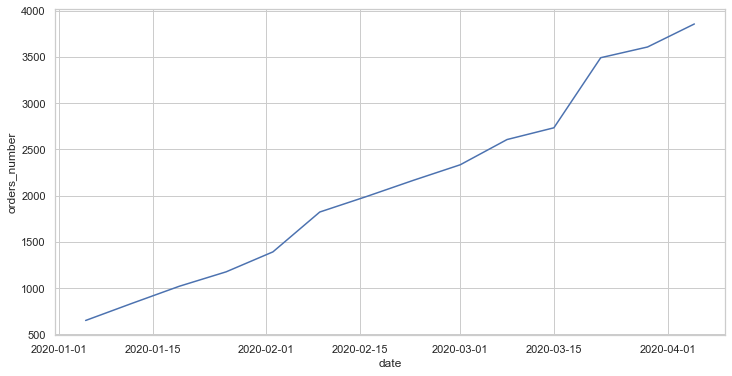

In [9]:
sns.lineplot(x=df.date, y=df.orders_number);

## Линейная регрессия

Очевидно, количество заказов возрастает линейно, а значит будем строить линейную регрессионную модель.

In [10]:
# добавим колонку с количеством недель для построения модели
df['week_number'] = pd.Series(df.date).diff().dt.days.div(7).fillna(0).astype(int).cumsum()
df

,date,orders_number,week_number
0,2020-01-05,650,0
1,2020-01-12,837,1
2,2020-01-19,1020,2
3,2020-01-26,1176,3
4,2020-02-02,1392,4
5,2020-02-09,1823,5
6,2020-02-16,1991,6
7,2020-02-23,2166,7
8,2020-03-01,2334,8
9,2020-03-08,2607,9


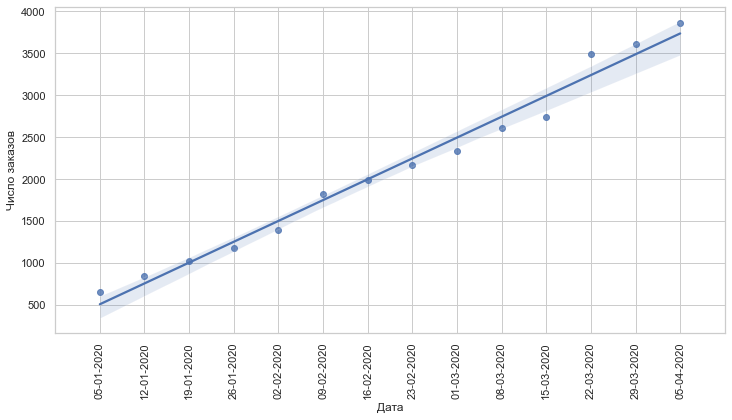

In [11]:
ax = sns.regplot(x='week_number', y='orders_number', data = df)
plt.xticks(range(0, 14))
x_labels = [(pd.to_datetime('2020-01-05') + pd.to_timedelta(i, unit='W')).strftime('%d-%m-%Y') for i in ax.get_xticks()]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_xlabel('Дата')
ax.set_ylabel('Число заказов')
ax.set_xlim([-1, 14]);

Посмотрим на силу взаимосвязи с помощью коэффициентов корреляции Пирсона и Спирмена

In [12]:
st.pearsonr(df.week_number, df.orders_number)

(0.990887213459399, 8.107805614582154e-12)

In [13]:
st.spearmanr(df.week_number, df.orders_number)

SpearmanrResult(correlation=1.0, pvalue=0.0)

Коэффициенты корреляции показывают наличие сильной статистически значимой положительной линейной взаимосвязи.

Построение линейной регрессионной модели:

In [14]:
st.linregress(df.week_number, df.orders_number)

LinregressResult(slope=248.59120879120877, intercept=504.65714285714307, rvalue=0.9908872134593987, pvalue=8.107805614583926e-12, stderr=9.754833167016818, intercept_stderr=74.6101270056913)

In [15]:
X = sm.add_constant(df.week_number)  # добавить константу, чтобы был свободный член
model = sm.OLS(df.orders_number, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          orders_number   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     649.4
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           8.11e-12
Time:                        13:53:30   Log-Likelihood:                -88.665
No. Observations:                  14   AIC:                             181.3
Df Residuals:                      12   BIC:                             182.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         504.6571     74.610      6.764      

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [16]:
results.params

const          504.657143
week_number    248.591209
dtype: float64

Показателем качества регрессионной модели является коэффициент детерминации (R-squared), который показывает насколько хорошо модель описывает данные. В нашем случае R-squared = 0.98, что говорит о высокой степени соответствия модели данным.
Полученная линейная модель имеет вид: y = 504.66 + 248.59*x, где y - количество заказов, x - количество недель, прошедших с даты начала наблюдений (2020-01-05). Поскольку p-value значительно меньше 0.05, то можно говорить том, что модель предсказывает значения статистически значимо.

Строим прогноз продаж с помощью линейной регрессионной модели.

In [17]:
x = np.linspace(0, 27, 28)
x = sm.add_constant(x)

In [18]:
results.predict(x)

array([ 504.65714286,  753.24835165, 1001.83956044, 1250.43076923,
       1499.02197802, 1747.61318681, 1996.2043956 , 2244.7956044 ,
       2493.38681319, 2741.97802198, 2990.56923077, 3239.16043956,
       3487.75164835, 3736.34285714, 3984.93406593, 4233.52527473,
       4482.11648352, 4730.70769231, 4979.2989011 , 5227.89010989,
       5476.48131868, 5725.07252747, 5973.66373626, 6222.25494505,
       6470.84615385, 6719.43736264, 6968.02857143, 7216.61978022])

In [19]:
d = {'date': pd.date_range(pd.to_datetime('2020-01-05'), periods=28, freq='1w').tolist(),
     'pred_values': results.predict(x)}

In [20]:
df_predict_all = pd.DataFrame(d)
df_predict_all

,date,pred_values
0,2020-01-05,504.657143
1,2020-01-12,753.248352
2,2020-01-19,1001.839560
3,2020-01-26,1250.430769
4,2020-02-02,1499.021978
5,2020-02-09,1747.613187
6,2020-02-16,1996.204396
7,2020-02-23,2244.795604
8,2020-03-01,2493.386813
9,2020-03-08,2741.978022


In [21]:
cmp_df_1 = df_predict_all.iloc[:14]

In [22]:
# Ошибки модели
cmp_df = pd.merge(cmp_df_1, df, on='date')
cmp_df.drop(columns=['week_number'], inplace=True)
cmp_df.rename(columns={'orders_number': 'orig_values'}, inplace=True)
cmp_df['e'] = cmp_df['orig_values'] - cmp_df['pred_values']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['orig_values']
mape = round(np.mean(abs(cmp_df['p'])), 2)
mae = round(np.mean(abs(cmp_df['e'])), 2)
print('MAPE (средняя абсолютная ошибка в процентах) –', mape,'%')
print('MAE (средняя абсолютная ошибка) –', mae)

MAPE (средняя абсолютная ошибка в процентах) – 6.52 %
MAE (средняя абсолютная ошибка) – 116.63


In [23]:
# сохраним ошибки модели для сравнения с Prophet моделью
d = {'model': 'linear model',
    'MAPE, %': mape,
    'MAE': mae}
df_comparison = pd.DataFrame(d, index=[0])

Построим итоговый график с исходными и cпрогнозированными данными.

In [24]:
df_predict = df_predict_all.iloc[14:].reset_index(drop=True)

In [25]:
df_predict['week_number'] = pd.Series(df_predict.date).diff().dt.days.div(7).fillna(14).astype('int').cumsum()
df_predict

,date,pred_values,week_number
0,2020-04-12,3984.934066,14
1,2020-04-19,4233.525275,15
2,2020-04-26,4482.116484,16
3,2020-05-03,4730.707692,17
4,2020-05-10,4979.298901,18
5,2020-05-17,5227.890110,19
6,2020-05-24,5476.481319,20
7,2020-05-31,5725.072527,21
8,2020-06-07,5973.663736,22
9,2020-06-14,6222.254945,23


In [26]:
df_predict.rename(columns={'pred_values': 'orders_number'}, inplace=True)

In [27]:
df['value_status'] = 'original'
df_predict['value_status'] = 'predicted'
df_final = pd.concat([df, df_predict]).reset_index(drop=True)
df_final

,date,orders_number,week_number,value_status
0,2020-01-05,650.000000,0,original
1,2020-01-12,837.000000,1,original
2,2020-01-19,1020.000000,2,original
3,2020-01-26,1176.000000,3,original
4,2020-02-02,1392.000000,4,original
5,2020-02-09,1823.000000,5,original
6,2020-02-16,1991.000000,6,original
7,2020-02-23,2166.000000,7,original
8,2020-03-01,2334.000000,8,original
9,2020-03-08,2607.000000,9,original


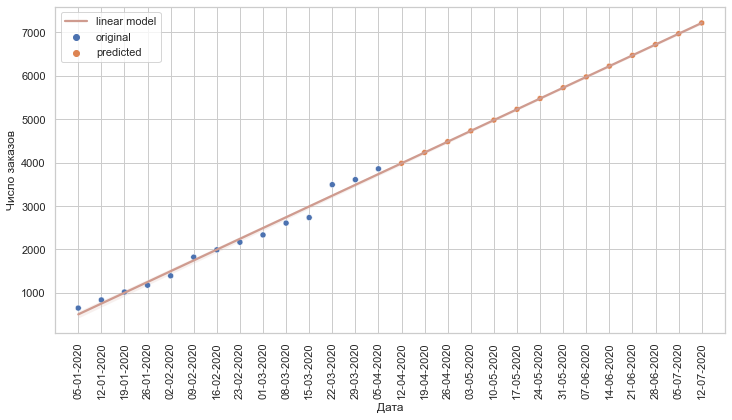

In [28]:
ax = sns.regplot(x='week_number', y='orders_number', data=df_final,
                 line_kws={"color": '#CF9B8F'}, scatter=False, label='linear model')
sns.scatterplot(x='week_number', y='orders_number', data=df_final, hue='value_status')

plt.xticks(range(0, 28))
x_labels = [(pd.to_datetime('2020-01-05') + pd.to_timedelta(i, unit='W')).strftime('%d-%m-%Y') for i in ax.get_xticks()]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_xlabel('Дата')
ax.set_ylabel('Число заказов')
ax.set_xlim([-1, 28])
plt.legend();

Добавим 95% доверительный интервал для модели.

In [29]:
ci = results.conf_int(0.05)
print(ci)

                      0           1
const        342.095641  667.218645
week_number  227.337253  269.845164


In [30]:
df_final['min_conf_int'] = ci[0][0] + df_final.week_number * ci[0][1]
df_final['max_conf_int'] = ci[1][0] + df_final.week_number * ci[1][1]
df_final

,date,orders_number,week_number,value_status,min_conf_int,max_conf_int
0,2020-01-05,650.000000,0,original,342.095641,667.218645
1,2020-01-12,837.000000,1,original,569.432894,937.063809
2,2020-01-19,1020.000000,2,original,796.770147,1206.908974
3,2020-01-26,1176.000000,3,original,1024.107400,1476.754138
4,2020-02-02,1392.000000,4,original,1251.444653,1746.599303
5,2020-02-09,1823.000000,5,original,1478.781907,2016.444467
6,2020-02-16,1991.000000,6,original,1706.119160,2286.289631
7,2020-02-23,2166.000000,7,original,1933.456413,2556.134796
8,2020-03-01,2334.000000,8,original,2160.793666,2825.979960
9,2020-03-08,2607.000000,9,original,2388.130919,3095.825125


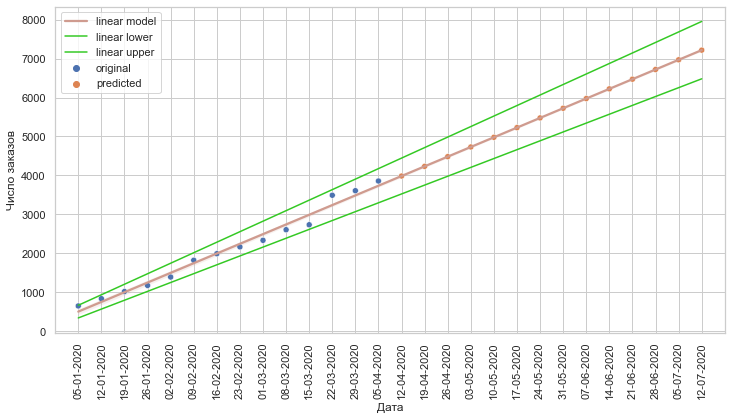

In [31]:
ax = sns.regplot(x='week_number', y='orders_number', data=df_final, 
                 line_kws={"color": '#CF9B8F'}, scatter=False, label='linear model')
sns.scatterplot(x='week_number', y='orders_number', data=df_final, hue='value_status')
sns.lineplot(x='week_number', y='min_conf_int', data=df_final, color='#34C924', label='linear lower')
sns.lineplot(x='week_number', y='max_conf_int', data=df_final, color='#34C924', label='linear upper')

plt.xticks(range(0, 28))
x_labels = [(pd.to_datetime('2020-01-05') + pd.to_timedelta(i, unit='W')).strftime('%d-%m-%Y') for i in ax.get_xticks()]
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_xlabel('Дата')
ax.set_ylabel('Число заказов')
ax.set_xlim([-1, 28])
plt.legend();

Все исходные данные входят в границы 95% доверительного интервала

Составим таблицу итогового прогноза с доверительными интервалами и сохраним в Excel для отчётности.

In [32]:
df_linear_prediction = df_final.query('value_status == "predicted"')[['date', 'orders_number', 'min_conf_int', 'max_conf_int']]

In [33]:
df_linear_prediction.orders_number = df_linear_prediction.orders_number.round().astype('int')
df_linear_prediction.min_conf_int = df_linear_prediction.min_conf_int.round().astype('int')
df_linear_prediction.max_conf_int = df_linear_prediction.max_conf_int.round().astype('int')
df_linear_prediction.rename(columns={'date': 'Дата', 'orders_number': 'Прогноз. число заказов',
                                     'min_conf_int': 'Мин. прогноз. число заказов', 
                                     'max_conf_int': 'Макс. прогноз. число заказов'}, inplace=True)
df_linear_prediction

,Дата,Прогноз. число заказов,Мин. прогноз. число заказов,Макс. прогноз. число заказов
14,2020-04-12,3985,3525,4445
15,2020-04-19,4234,3752,4715
16,2020-04-26,4482,3979,4985
17,2020-05-03,4731,4207,5255
18,2020-05-10,4979,4434,5524
19,2020-05-17,5228,4662,5794
20,2020-05-24,5476,4889,6064
21,2020-05-31,5725,5116,6334
22,2020-06-07,5974,5344,6604
23,2020-06-14,6222,5571,6874


In [34]:
df_linear_prediction.to_excel("lm_prediction_report.xlsx", index=False)

**Вывод:**  
Для предсказания количества продаж была использована линейная регрессионная модель, которая согласно коэффициенту детерминации (R-squared) = 0.98 показывает высокую степень соответствия модели данным.  
В результате получена таблица с прогнозируемыми значениями количества продаж на ближайшие 3 месяца с минимальными и максимальными границами значений (нижними и верхними границами 95% доверительного интервала).  
Также стоит отметить, что данных для построения регрессионной модели весьма мало (только 14 наблюдений), что может негативно сказаться на точности дальнейшего, тем более долгосрочного, прогноза. Если у нас имеются данные о насыщении рынка, предполагаемое значение максимально возможного количества заказов или данные о внешних событиях, которые могут существенно повлиять на заказы, то стоит сделать на это поправку и ограничить верхнюю границу прогноза.

## Prophet модель

Для сравнения построим предсказательную модель с помощью библиотеки Prophet

In [35]:
from fbprophet import Prophet
import holidays
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

Загрузка и предобработка данных

In [36]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

In [37]:
df.rename(columns={'Дата': 'ds', 'Число заказов': 'y'}, inplace=True)

In [38]:
df.ds = pd.to_datetime(df.ds)

In [39]:
df

,ds,y
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


Вносим поправку в данные о заказах с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [40]:
adj_y = df[df['ds'] == pd.to_datetime('2020-02-02')].y.div(1.07).round().astype(int)
df.loc[df['ds'] == pd.to_datetime('2020-02-02'), 'y'] = adj_y
df

,ds,y
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1392
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


In [41]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [42]:
# Составляем датафрейм с праздниками, для их учёта моделью
holidays_dict = holidays.RU(years=(2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2020-01-01,Новый год
1,2020-01-02,Новый год
2,2020-01-03,Новый год
3,2020-01-04,Новый год
4,2020-01-05,Новый год
5,2020-01-06,Новый год
6,2020-01-07,Православное Рождество
7,2020-01-08,Новый год
8,2020-02-23,День защитника отечества
9,2020-03-08,День женщин


Настраиваем prophet – говорим ему учитывать праздники и сезонности:

In [43]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.fit(df)

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Строим прогноз на 3 месяца (14 недель):

In [44]:
predictions = 14
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)

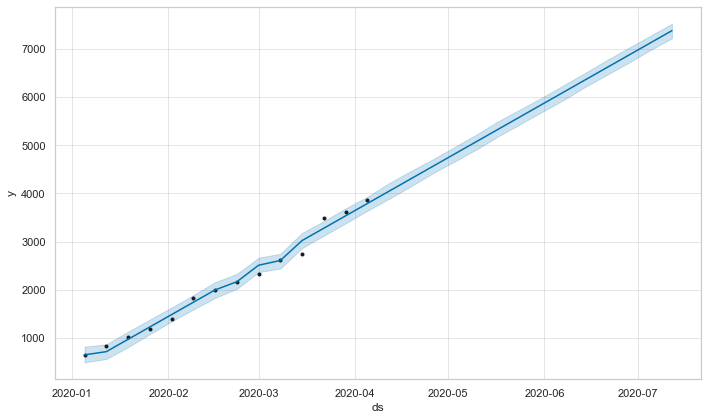

In [45]:
# Смотрим, что предсказалось
m.plot(forecast);

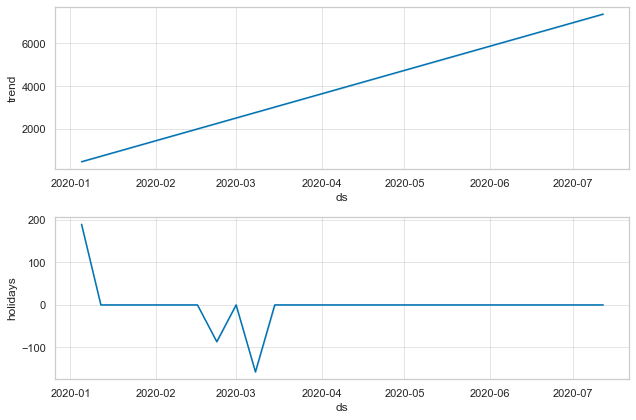

In [46]:
# Смотрим на сезонности
m.plot_components(forecast);

Рисуем график с границами прогноза:

In [47]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower')
])

In [48]:
# Ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df = cmp_df.iloc[:14]
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
mape = round(np.mean(abs(cmp_df['p'])), 2)
mae = round(np.mean(abs(cmp_df['e'])), 2)
print('MAPE (средняя абсолютная ошибка в процентах) –', mape,'%')
print('MAE (средняя абсолютная ошибка) –', mae)

MAPE (средняя абсолютная ошибка в процентах) – 4.5 %
MAE (средняя абсолютная ошибка) – 87.32


In [49]:
# сохраним ошибки модели для сравнения с линейной моделью
d = {'model': 'prophet model',
    'MAPE, %': mape,
    'MAE': mae}
df_comparison = df_comparison.append(pd.DataFrame(d, index=[1]))

In [50]:
df_prophet_prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)
df_prophet_prediction = df_prophet_prediction.iloc[14:].reset_index(drop=True)
df_prophet_prediction

,ds,yhat,yhat_lower,yhat_upper
0,2020-04-12,4044.049961,3885.814337,4211.261028
1,2020-04-19,4300.008319,4143.864552,4459.666640
2,2020-04-26,4555.966676,4412.680843,4702.088359
3,2020-05-03,4811.925034,4655.451228,4957.439726
4,2020-05-10,5067.883391,4904.755204,5214.411071
5,2020-05-17,5323.841749,5176.414441,5489.160007
6,2020-05-24,5579.800106,5426.624739,5732.292866
7,2020-05-31,5835.758464,5679.133608,5977.545222
8,2020-06-07,6091.716821,5927.633765,6235.206420
9,2020-06-14,6347.675179,6202.355834,6493.926366


Составим таблицу итогового прогноза с доверительными интервалами и сохраним в Excel для отчётности.

In [51]:
df_prophet_prediction.yhat = df_prophet_prediction.yhat.round().astype(int)
df_prophet_prediction.yhat_lower = df_prophet_prediction.yhat_lower.round().astype(int)
df_prophet_prediction.yhat_upper = df_prophet_prediction.yhat_upper.round().astype(int)
df_prophet_prediction.rename(columns={'ds': 'Дата', 'yhat': 'Прогноз. число заказов',
                                     'yhat_lower': 'Мин. прогноз. число заказов', 
                                     'yhat_upper': 'Макс. прогноз. число заказов'}, inplace=True)
df_prophet_prediction

,Дата,Прогноз. число заказов,Мин. прогноз. число заказов,Макс. прогноз. число заказов
0,2020-04-12,4044,3886,4211
1,2020-04-19,4300,4144,4460
2,2020-04-26,4556,4413,4702
3,2020-05-03,4812,4655,4957
4,2020-05-10,5068,4905,5214
5,2020-05-17,5324,5176,5489
6,2020-05-24,5580,5427,5732
7,2020-05-31,5836,5679,5978
8,2020-06-07,6092,5928,6235
9,2020-06-14,6348,6202,6494


In [52]:
df_prophet_prediction.to_excel('prophet_prediction_report.xlsx', index=False)

## Сравнение моделей

Данные линейной модели:

In [53]:
df_linear = (
                df_final
                .query('value_status == "predicted"')[['date', 'orders_number', 'min_conf_int', 'max_conf_int']]
                .reset_index(drop=True)
            )

Данные Prophet модели:

In [54]:
df_prophet = (
                forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
                .iloc[14:]
                .reset_index(drop=True)
             )

Объединяем данные моделей в один датафрейм

In [55]:
df_prophet.rename(columns={'ds':'date'}, inplace=True)
df = pd.merge(df_linear, df_prophet, on='date')
df['models_diff'] = df.yhat - df.orders_number
df.rename(columns={'orders_number':'lm_prediction', 'min_conf_int': 'lm_lower', 'max_conf_int': 'lm_upper',
                   'yhat':'prophet_prediction', 'yhat_lower': 'prophet_lower', 'yhat_upper': 'prophet_upper'}, inplace=True)
df

,date,lm_prediction,lm_lower,lm_upper,prophet_prediction,prophet_lower,prophet_upper,models_diff
0,2020-04-12,3984.934066,3524.817185,4445.050947,4044.049961,3885.814337,4211.261028,59.115895
1,2020-04-19,4233.525275,3752.154438,4714.896112,4300.008319,4143.864552,4459.666640,66.483044
2,2020-04-26,4482.116484,3979.491691,4984.741276,4555.966676,4412.680843,4702.088359,73.850193
3,2020-05-03,4730.707692,4206.828944,5254.586440,4811.925034,4655.451228,4957.439726,81.217341
4,2020-05-10,4979.298901,4434.166197,5524.431605,5067.883391,4904.755204,5214.411071,88.584490
5,2020-05-17,5227.890110,4661.503450,5794.276769,5323.841749,5176.414441,5489.160007,95.951639
6,2020-05-24,5476.481319,4888.840704,6064.121934,5579.800106,5426.624739,5732.292866,103.318787
7,2020-05-31,5725.072527,5116.177957,6333.967098,5835.758464,5679.133608,5977.545222,110.685936
8,2020-06-07,5973.663736,5343.515210,6603.812263,6091.716821,5927.633765,6235.206420,118.053085
9,2020-06-14,6222.254945,5570.852463,6873.657427,6347.675179,6202.355834,6493.926366,125.420234


Строим сравнительные графики прогнозов с доверительными интервалами моделей

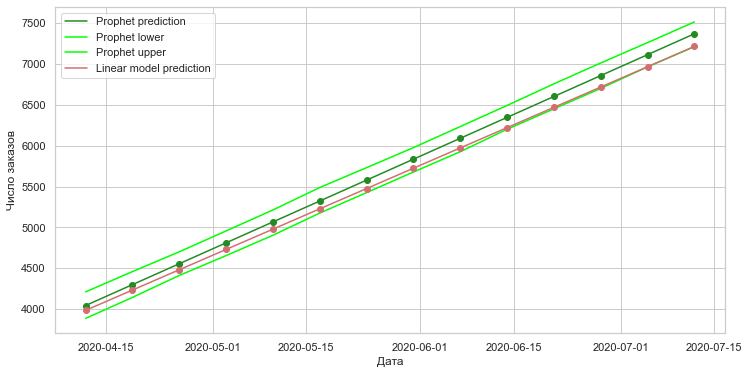

In [56]:
ax = sns.lineplot(x='date', y='prophet_prediction', data=df, label='Prophet prediction', color='#228B22')
plt.plot(df.date, df.prophet_prediction, 'ro', c='#228B22')
sns.lineplot(x='date', y='prophet_lower', data=df, label='Prophet lower', color='#00FF00')
sns.lineplot(x='date', y='prophet_upper', data=df, label='Prophet upper', color='#00FF00')

sns.lineplot(x='date', y='lm_prediction', data=df, label='Linear model prediction', color='#D36E70')
plt.plot(df.date, df.lm_prediction, 'ro', c='#D36E70')

ax.set_xlabel('Дата')
ax.set_ylabel('Число заказов')
plt.legend();

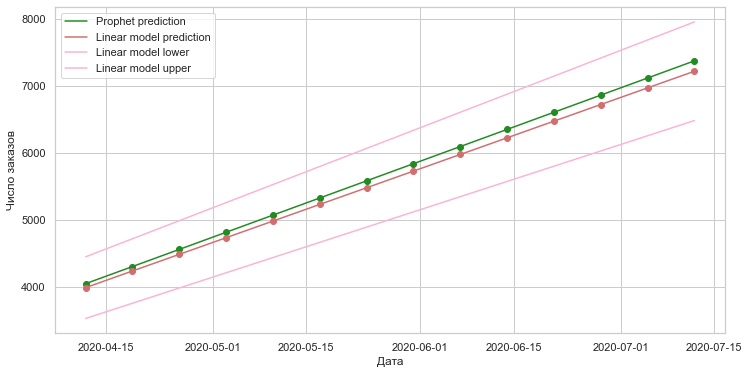

In [57]:
ax = sns.lineplot(x='date', y='prophet_prediction', data=df, label='Prophet prediction', color='#228B22')
plt.plot(df.date, df.prophet_prediction, 'ro', c='#228B22')

sns.lineplot(x='date', y='lm_prediction', data=df, label='Linear model prediction', color='#D36E70')
plt.plot(df.date, df.lm_prediction, 'ro', c='#D36E70')
sns.lineplot(x='date', y='lm_lower', data=df, label='Linear model lower', color='#FCB4D5')
sns.lineplot(x='date', y='lm_upper', data=df, label='Linear model upper', color='#FCB4D5')

ax.set_xlabel('Дата')
ax.set_ylabel('Число заказов')
plt.legend();

In [58]:
df_comparison

,model,"MAPE, %",MAE
0,linear model,6.52,116.63
1,prophet model,4.50,87.32


**Вывод по выбору модели:**  
Обе модели похожи, имеют линейный характер и хорошо описывают данные. Модель от Prophet немного более оптимистична и прогнозирует большие значения продаж, чем линейная модель, и обе входят в доверительные интервалы друг друга на заданном промежутке прогнозирования (далее линейная модель начинаяет выходить за узкие доверительные интервалы Prophet модели).  
Линейная модель уступает модели Prophet по показателям MAPE (средняя абсолютная ошибка в процентах) и MAE (средняя абсолютная ошибка), но стоит учитывать, что чем меньше данных (в данном случае дано всего 14 точек), тем больше доверия должно быть более простой модели. Модель Prophet с учётом сезонности, праздников, переломных точек тренда является далеко не простой моделью, а значит верить её предсказаниям не стоит, и **следует отдать предпочтение более простой линейной модели**.